## Extract Zip files

In [32]:
import os
import zipfile

# Define the base directory where ZIP files are located
base_dir = "New SkinDisease"
extract_dir = os.path.join(base_dir, "extracted")

# Ensure the extracted directory exists
os.makedirs(extract_dir, exist_ok=True)

# Loop through all folders and extract ZIP files separately
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".zip"):
            zip_path = os.path.join(root, file)
            folder_name = os.path.splitext(file)[0]  # Get ZIP filename without extension
            target_dir = os.path.join(extract_dir, folder_name)  # Create a separate folder
            os.makedirs(target_dir, exist_ok=True)  # Ensure folder exists

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(target_dir)  # Extract into separate folder
            print(f"Extracted: {file} → {target_dir}")

Extracted: Acne_0.zip → New SkinDisease\extracted\Acne_0
Extracted: Acne_1.zip → New SkinDisease\extracted\Acne_1
Extracted: Eczema_0.zip → New SkinDisease\extracted\Eczema_0
Extracted: Eczema_1.zip → New SkinDisease\extracted\Eczema_1
Extracted: Melasma_0.zip → New SkinDisease\extracted\Melasma_0
Extracted: Melasma_1.zip → New SkinDisease\extracted\Melasma_1
Extracted: Melasma_2.zip → New SkinDisease\extracted\Melasma_2
Extracted: Melasma_3.zip → New SkinDisease\extracted\Melasma_3
Extracted: Rosacea_0.zip → New SkinDisease\extracted\Rosacea_0
Extracted: Shingles_0.zip → New SkinDisease\extracted\Shingles_0
Extracted: Shingles_1.zip → New SkinDisease\extracted\Shingles_1


## Step 1: Remove Augmented Images

✅ Why? To ensure that augmentation is applied consistently across all datasets.

Extract original (non-augmented) images from each ZIP file.

Keep only raw images for each skin condition.

### Scans

counting the number of images

displays hiearchy of the structure

In [127]:
import os

# Define the root directory to scan
root_dir = "New SkinDisease/training_data"

# ANSI escape codes for colors
CYAN = "\033[96m"
YELLOW = "\033[93m"
GREEN = "\033[92m"
BOLD = "\033[1m"
RESET = "\033[0m"

# Function to count files in a folder
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Function to count total images and labels in a dataset folder
def count_dataset_items(dataset_path):
    total_images, total_labels = 0, 0
    for split in ["train", "valid", "test"]:
        split_path = os.path.join(dataset_path, split)
        images_path = os.path.join(split_path, "images")
        labels_path = os.path.join(split_path, "labels")

        if os.path.isdir(images_path):
            total_images += count_files(images_path)
        if os.path.isdir(labels_path):
            total_labels += count_files(labels_path)

    return total_images, total_labels

# Function to recursively scan and display folder hierarchy with image/label counts
def scan_folders(directory, indent=0):
    if not os.path.exists(directory):
        print(f"{YELLOW}⚠️ Directory not found!{RESET}")
        return

    for item in sorted(os.listdir(directory)):  # Sort for consistent order
        item_path = os.path.join(directory, item)
        prefix = " " * indent + "|-- "  # Indentation for hierarchy visualization
        
        if os.path.isdir(item_path):
            if item in ["images", "labels"]:  # Count files instead of listing them
                file_count = count_files(item_path)
                print(f"{CYAN}{prefix}📂 {BOLD}{item}{RESET} ({file_count} files)")
            else:
                # Count total images and labels for dataset folders
                total_images, total_labels = count_dataset_items(item_path)
                
                # Format the display string (hide 0 values)
                count_text = []
                if total_images > 0:
                    count_text.append(f"✅ {total_images} images")
                if total_labels > 0:
                    count_text.append(f"✅ {total_labels} labels")
                
                count_display = " ".join(count_text) if count_text else ""  
                print(f"{CYAN}{prefix}📂 {BOLD}{item}{RESET} {count_display}")
                
                scan_folders(item_path, indent + 4)  # Recursively scan subfolders
        else:
            print(f"{GREEN}{prefix}📄 {item}{RESET}")

# Run the folder scan
print(f"\n{BOLD}📁 Scanning folder hierarchy in:{RESET} {CYAN}{root_dir}{RESET}\n")
scan_folders(root_dir)



📁 Scanning folder hierarchy in: New SkinDisease/training_data

|-- 📄 data.yml
|-- 📂 test 
    |-- 📂 images (500 files)
    |-- 📂 labels (500 files)
|-- 📂 train 
    |-- 📂 images (7000 files)
    |-- 📂 labels (7000 files)
|-- 📂 valid 
    |-- 📂 images (1000 files)
    |-- 📂 labels (1000 files)


### Scan all labels format

Scan all labels each dataset that it should be in a rectangular fomat not polygon


In [39]:
import os
from termcolor import colored

# Check if a string can be converted to float
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Function to check a label file and return reasons for invalid lines
def check_label_file(label_path):
    invalid = False
    error_types = {"wrong_element_count": 0, "non_digit_class": 0, "non_float_coordinates": 0}
    try:
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
            for idx, line in enumerate(lines):
                stripped = line.strip()
                if not stripped:
                    continue  # Allow empty lines
                parts = stripped.split()

                # Check if line has exactly 5 values
                if len(parts) != 5:
                    error_types["wrong_element_count"] += 1
                    invalid = True
                    continue

                # Check if first is digit and rest are float
                if not parts[0].isdigit():
                    error_types["non_digit_class"] += 1
                    invalid = True
                    continue

                if not all(is_float(p) for p in parts[1:]):
                    error_types["non_float_coordinates"] += 1
                    invalid = True
                    continue

        return invalid, error_types
    except Exception as e:
        print(colored(f"Error reading {label_path}: {e}", 'red'))
        return True, error_types

# Scan all label files inside a dataset
def scan_labels(dataset_path):
    invalid_count = 0
    error_summary = {"wrong_element_count": 0, "non_digit_class": 0, "non_float_coordinates": 0}
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.txt') and "README" not in file:
                label_path = os.path.join(root, file)
                invalid, errors = check_label_file(label_path)
                if invalid:
                    invalid_count += 1
                    for error_type in errors:
                        error_summary[error_type] += errors[error_type]
                        
    return invalid_count, error_summary

# Root folder
root_folder = r'New SkinDisease/extracted'

# Track results
results = {}

# Scan each dataset
for dataset_name in sorted(os.listdir(root_folder)):
    dataset_path = os.path.join(root_folder, dataset_name)
    if os.path.isdir(dataset_path):
        print(colored(f"\nChecking dataset: {dataset_name}", 'cyan'))
        invalid_count, error_summary = scan_labels(dataset_path)
        results[dataset_name] = {"invalid_count": invalid_count, "error_summary": error_summary}

# Print results
total_invalid = sum(result["invalid_count"] for result in results.values())
total_errors = {"wrong_element_count": 0, "non_digit_class": 0, "non_float_coordinates": 0}

print(colored("\nSummary of Label Format Checks:", 'yellow'))
for name, result in results.items():
    if result["invalid_count"] > 0:
        print(colored(f"{name}: Invalid label files: {result['invalid_count']}", 'red'))
        for error_type, count in result["error_summary"].items():
            if count > 0:
                print(colored(f"  {error_type.replace('_', ' ').capitalize()}: {count}", 'red'))
        for error_type in result["error_summary"]:
            total_errors[error_type] += result["error_summary"][error_type]
    else:
        print(colored(f"{name}: No invalid labels", 'green'))

print(colored(f"\nTotal Invalid Label Files Found: {total_invalid}", 'red' if total_invalid > 0 else 'green'))

# Print total errors across all datasets
print(colored("\nTotal Error Summary Across All Datasets:", 'yellow'))
for error_type, count in total_errors.items():
    if count > 0:
        print(colored(f"{error_type.replace('_', ' ').capitalize()}: {count}", 'red'))



Checking dataset: Acne_0

Checking dataset: Acne_1

Checking dataset: Eczema_0

Checking dataset: Eczema_1

Checking dataset: Melasma_0

Checking dataset: Melasma_1

Checking dataset: Melasma_2

Checking dataset: Melasma_3

Checking dataset: Rosacea_0

Checking dataset: Shingles_0

Checking dataset: Shingles_1

Summary of Label Format Checks:
Acne_0: No invalid labels
Acne_1: No invalid labels
Eczema_0: No invalid labels
Eczema_1: No invalid labels
Melasma_0: No invalid labels
Melasma_1: No invalid labels
Melasma_2: No invalid labels
Melasma_3: No invalid labels
Rosacea_0: No invalid labels
Shingles_0: No invalid labels
Shingles_1: No invalid labels

Total Invalid Label Files Found: 0

Total Error Summary Across All Datasets:


### Convert all polygon format to rectangular format

In [38]:
import os

# Function to convert polygon coordinates to bounding box format
def polygon_to_bbox(polygon):
    # Convert the polygon points from strings to floats
    coords = [float(v) for v in polygon]

    # Separate x and y coordinates
    x_coords = coords[0::2]  # even indices (x)
    y_coords = coords[1::2]  # odd indices (y)

    # Calculate the bounding box (min and max coordinates)
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)

    # Calculate YOLO format values (center_x, center_y, width, height)
    width = max_x - min_x
    height = max_y - min_y
    x_center = (min_x + max_x) / 2
    y_center = (min_y + max_y) / 2

    return x_center, y_center, width, height

# Function to process and convert all label files in the dataset
def convert_polygon_labels_to_bbox(dataset_path):
    # Traverse the dataset folder
    for root, dirs, files in os.walk(dataset_path):
        for label_filename in files:
            if label_filename.endswith('.txt') and "README" not in label_filename:  # Ensure it's a label file and not README
                label_path = os.path.join(root, label_filename)

                # Read the label file (polygon format)
                with open(label_path, 'r') as label_file:
                    lines = label_file.readlines()

                # Process each line and convert the polygon to bounding box
                new_lines = []
                for line in lines:
                    parts = line.strip().split()

                    # Ensure there is at least one polygon (coordinates)
                    if len(parts) > 1:
                        try:
                            # Extract the polygon points (coordinates) from the line
                            polygon = parts[1:]  # Polygon coordinates start from index 1

                            # Convert the polygon to bounding box format
                            x_center, y_center, width, height = polygon_to_bbox(polygon)

                            # Write the converted line
                            new_lines.append(f"{parts[0]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                        except Exception as e:
                            print(f"Error processing line in {label_filename}: {e}")
                            new_lines.append(f"# Error: {e}\n")
                    else:
                        # If the line doesn't contain a polygon, write it as is
                        new_lines.append(line)

                # Write the converted lines back to the file
                if new_lines:
                    with open(label_path, 'w') as label_file:
                        label_file.writelines(new_lines)

# Define the path to the dataset folder
dataset_path = r'New SkinDisease/extracted'

# Ensure the directory exists
if not os.path.isdir(dataset_path):
    print(f"Error: Directory {dataset_path} does not exist.")
else:
    # Process all files in the dataset folder
    converted_count = 0
    for dataset_name in os.listdir(dataset_path):
        dataset_full_path = os.path.join(dataset_path, dataset_name)
        if os.path.isdir(dataset_full_path):  # Only process subdirectories
            print(f"\nConverting labels in dataset: {dataset_name}")
            convert_polygon_labels_to_bbox(dataset_full_path)
            converted_count += 1

    if converted_count == 0:
        print("No datasets found to convert. Please check the folder structure.")
    else:
        print(f"✅ {converted_count} datasets processed and converted!")

print("Conversion complete!")



Converting labels in dataset: Acne_0

Converting labels in dataset: Acne_1

Converting labels in dataset: Eczema_0

Converting labels in dataset: Eczema_1

Converting labels in dataset: Melasma_0

Converting labels in dataset: Melasma_1

Converting labels in dataset: Melasma_2

Converting labels in dataset: Melasma_3

Converting labels in dataset: Rosacea_0

Converting labels in dataset: Shingles_0

Converting labels in dataset: Shingles_1
✅ 11 datasets processed and converted!
Conversion complete!


### Visual check

check random images of labels whether it is correct

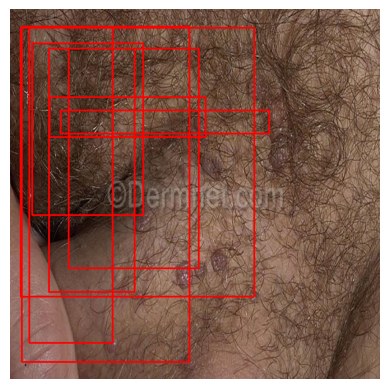

In [98]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Function to read and parse the YOLO-style label file
def read_bbox(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            if len(parts) > 1:
                class_id, x_center, y_center, width, height = map(float, parts)
                bboxes.append((class_id, x_center, y_center, width, height))
    return bboxes

# Function to display image with bounding boxes
def display_image_with_bboxes(image_path, label_path):
    image = cv2.imread(image_path)  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying with matplotlib

    bboxes = read_bbox(label_path)  # Get bounding boxes from label

    # Draw bounding boxes
    for bbox in bboxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert YOLO format to pixel coordinates
        image_width, image_height = image.shape[1], image.shape[0]
        x1 = int((x_center - width / 2) * image_width)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red bounding box

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Path to the dataset folder
dataset_path = 'New SkinDisease/extracted/Shingles_0/train'  # Change this to the folder where images/labels are located

# Get all image files from the dataset (add .jpeg extension if needed)
image_files = [f for f in os.listdir(os.path.join(dataset_path, 'images')) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]

# Check if image files exist
if not image_files:
    print("No image files found in the specified directory.")
else:
    # Select a random image
    random_image_file = random.choice(image_files)
    image_path = os.path.join(dataset_path, 'images', random_image_file)

    # Find the corresponding label file
    label_file = random_image_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
    label_path = os.path.join(dataset_path, 'labels', label_file)

    # Display the image with bounding boxes
    display_image_with_bboxes(image_path, label_path)


### Show sum of each dataset

In [121]:
import os
from collections import defaultdict

# Root directory
root_dir = "New SkinDisease/extracted"

# ANSI colors
CYAN = "\033[96m"
YELLOW = "\033[93m"
GREEN = "\033[92m"
BOLD = "\033[1m"
RESET = "\033[0m"

# Count files in a folder
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Count images and labels in a dataset
def count_dataset_items(dataset_path):
    total_images, total_labels = 0, 0
    for split in ["train", "valid", "test"]:
        images_path = os.path.join(dataset_path, split, "images")
        labels_path = os.path.join(dataset_path, split, "labels")

        if os.path.isdir(images_path):
            total_images += count_files(images_path)
        if os.path.isdir(labels_path):
            total_labels += count_files(labels_path)

    return total_images, total_labels

# Scan dataset folders
def scan_datasets(directory):
    if not os.path.exists(directory):
        print(f"{YELLOW}⚠️ Directory not found!{RESET}")
        return

    dataset_totals = defaultdict(int)

    for dataset_name in sorted(os.listdir(directory)):
        dataset_path = os.path.join(directory, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        total_images, total_labels = count_dataset_items(dataset_path)

        print(f"{CYAN}📂 {BOLD}{dataset_name}{RESET} — ✅ {total_images} images, ✅ {total_labels} labels")

        base_name = dataset_name.split('_')[0]  # E.g., 'Acne' from 'Acne_0'
        dataset_totals[base_name] += total_images

    # Print group totals
    print(f"\n{BOLD}📊 Group Totals:{RESET}")
    for name, total in dataset_totals.items():
        print(f"{GREEN}🧮 Total {name} = {total} images{RESET}")

# Run
print(f"\n{BOLD}📁 Scanning datasets in:{RESET} {CYAN}{root_dir}{RESET}\n")
scan_datasets(root_dir)



📁 Scanning datasets in: New SkinDisease/extracted

📂 Acne_0 — ✅ 315 images, ✅ 315 labels
📂 Acne_1 — ✅ 1000 images, ✅ 1000 labels
📂 Eczema_0 — ✅ 1000 images, ✅ 1000 labels
📂 Eczema_1 — ✅ 1000 images, ✅ 1000 labels
📂 Melasma_0 — ✅ 121 images, ✅ 121 labels
📂 Melasma_1 — ✅ 308 images, ✅ 308 labels
📂 Melasma_2 — ✅ 69 images, ✅ 69 labels
📂 Melasma_3 — ✅ 1000 images, ✅ 1000 labels
📂 Rosacea_0 — ✅ 1000 images, ✅ 1000 labels
📂 Shingles_0 — ✅ 871 images, ✅ 871 labels
📂 Shingles_1 — ✅ 1000 images, ✅ 1000 labels

📊 Group Totals:
🧮 Total Acne = 1315 images
🧮 Total Eczema = 2000 images
🧮 Total Melasma = 1498 images
🧮 Total Rosacea = 1000 images
🧮 Total Shingles = 1871 images


### Read all README.roboflow.txt each dataset

In [23]:
import os

def read_roboflow_readme(root_folder):
    ignore_lines = [
        "Roboflow is an end-to-end computer vision platform that helps you",
        "* collaborate with your team on computer vision projects",
        "* collect & organize images",
        "* understand and search unstructured image data",
        "* annotate, and create datasets",
        "* export, train, and deploy computer vision models",
        "* use active learning to improve your dataset over time",
        "For state of the art Computer Vision training notebooks you can use with this dataset,",
        "visit https://github.com/roboflow/notebooks",
        "To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com"
    ]

    # ANSI escape codes for colors
    BLUE = "\033[94m"
    BOLD = "\033[1m"
    RESET = "\033[0m"

    for dataset_folder in os.listdir(root_folder):
        dataset_path = os.path.join(root_folder, dataset_folder)
        if os.path.isdir(dataset_path):  # Ensure it's a directory
            readme_path = os.path.join(dataset_path, "README.roboflow.txt")
            
            if os.path.exists(readme_path):  # Check if README file exists
                print(f"\n{BLUE}{BOLD}📂 Reading: {dataset_folder}/README.roboflow.txt 📄{RESET}\n")
                with open(readme_path, "r", encoding="utf-8") as f:
                    for line in f:
                        line = line.strip()
                        if not any(line.startswith(ignore) for ignore in ignore_lines):
                            print(line)  # Display filtered README contents  

                # Count images and labels
                total_images, total_labels = 0, 0
                for split in ["train", "valid", "test"]:
                    split_path = os.path.join(dataset_path, split)
                    images_path = os.path.join(split_path, "images")
                    labels_path = os.path.join(split_path, "labels")

                    if os.path.isdir(images_path):  # Check if images folder exists
                        total_images += len(os.listdir(images_path))
                    if os.path.isdir(labels_path):  # Check if labels folder exists
                        total_labels += len(os.listdir(labels_path))

                print(f"\n✅ {BOLD}Total Images:{RESET} {total_images}, {BOLD}Total Labels:{RESET} {total_labels}\n")

# Set the correct dataset directory path
root_folder = "New SkinDisease/extracted"  # Adjust this if needed
read_roboflow_readme(root_folder)



📂 Reading: Acne_0/README.roboflow.txt 📄


Acne_Detection_Sai - v2 2024-05-22 11:31am

This dataset was exported via roboflow.com on May 27, 2024 at 9:05 AM GMT




The dataset includes 2513 images.
Acne are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

The following augmentation was applied to create 3 versions of each source image:
* Equal probability of one of the following 90-degree rotations: none, clockwise, counter-clockwise
* Salt and pepper noise was applied to 0.12 percent of pixels



✅ Total Images: 2513, Total Labels: 2513


📂 Reading: Acne_1/README.roboflow.txt 📄


AcneV2 - v2 AcneV2

This dataset was exported via roboflow.com on February 20, 2025 at 4:23 PM GMT




The dataset includes 1282 images.
Pimple are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Resize to 640x640 (Stretch)

The following

### Scanning augmented datas

In [22]:
import os
import cv2
import numpy as np

# Define dataset directories
dataset_path = r'New SkinDisease\extracted\Eczema_0'
folders = ['train', 'valid', 'test']

def calculate_variation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if image is None:
        return 0  # If the image cannot be read, return 0 variation
    return np.var(image)  # Compute variance

total_variations = {}  # Dictionary to store total variations per folder
total_overall_variation = 0  # Initialize total variation across all folders
image_counts = {}  # Dictionary to count images per folder

# Iterate over each folder and compute total variation
for folder in folders:
    folder_path = os.path.join(dataset_path, folder, 'images')  # Path to images
    total_variation = 0  # Initialize total variation for this folder
    image_count = 0  # Counter for images processed

    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid images
                continue

            image_path = os.path.join(folder_path, filename)
            variation = calculate_variation(image_path)
            total_variation += variation
            image_count += 1  # Increment image count

            # Debugging: Print variance for first 5 images
            if image_count <= 5:
                print(f'Image: {filename}, Variance: {variation}')

    total_variations[folder] = total_variation
    total_overall_variation += total_variation
    image_counts[folder] = image_count  # Store image count

# Print results
for folder, variation in total_variations.items():
    print(f'Total Variation in {folder}: {variation}, Images Processed: {image_counts.get(folder, 0)}')

print(f'Overall Total Variation: {total_overall_variation}')

# Prevent ZeroDivisionError
total_images = sum(image_counts.values())
if total_images > 0:
    avg_variation = total_overall_variation / total_images
    print(f'Average Variance per Image: {avg_variation:.2f}')
else:
    print("No images found. Check dataset path and file structure.")




Image: 0_0_jpg.rf.7c26a2d91510b5e5ddbf0725ea989ec5.jpg, Variance: 1213.5512642939623
Image: 0_10_jpg.rf.7223cbc1d891d8094299a7e65d4b3105.jpg, Variance: 3322.0291218203865
Image: 0_11_jpg.rf.95135974e2b5753e9666841c14b39abb.jpg, Variance: 1306.438055398585
Image: 0_12_jpg.rf.e1cbeb638984157a32c20b9eeac362cc.jpg, Variance: 2129.1913306990086
Image: 0_13_jpg.rf.59cc73b3df496a456ab0d55e96f5ecc2.jpg, Variance: 2640.7441368354484
Image: 0_18_jpg.rf.45d9c3394406a91d40fa780c2bb81382.jpg, Variance: 2481.788153088072
Image: 0_1_jpg.rf.1ea6d9f5cb32d99102ae0c2a437f8ffd.jpg, Variance: 968.5662271989788
Image: 0_22_jpg.rf.40df16df66c350117cc1ef345888ded2.jpg, Variance: 921.6342893626993
Image: 0_23_jpg.rf.86f535648509f2d59ac8918f2fe8c3a7.jpg, Variance: 957.0707238629453
Image: 0_2_jpg.rf.ead5e16689b5af9863d45db9d0aa6dea.jpg, Variance: 3903.700160990703
Image: 0_25_jpg.rf.70c40908d573f748379dcfd7dcf7f8ed.jpg, Variance: 4088.0130454106315
Image: 0_26_jpg.rf.ef796d32dcb97dd8434751d252bd2b8d.jpg, Varian

### Scans Duplication

In [26]:
import os
from collections import defaultdict

# Define dataset path
dataset_path = r'New SkinDisease\extracted\Eczema_1'
folders = ['train', 'valid', 'test']
image_exts = ('.jpg', '.png', '.jpeg')

# Dictionary to store duplicate counts
duplicate_counts = defaultdict(int)
duplicate_files = defaultdict(list)

# Process each folder
for folder in folders:
    image_folder = os.path.join(dataset_path, folder, 'images')

    if not os.path.exists(image_folder):
        continue

    filename_dict = defaultdict(list)  # Store all files with the same base name

    # Check all images in the folder
    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(image_exts):
            continue  # Skip non-image files

        # Extract base filename (before .rf.<hash> part)
        base_name = filename.rsplit('_', 1)[0]  # Assumes filenames follow the pattern "name.rf.hash.jpg"

        filename_dict[base_name].append(filename)

    # Store duplicates
    for base_name, files in filename_dict.items():
        if len(files) > 1:
            duplicate_counts[folder] += len(files) - 1  # Count extra copies
            duplicate_files[folder].append((files[0], len(files)))  # Store example filename and count

# Display results
total_duplicates = 0
for folder, count in duplicate_counts.items():
    print(f'Folder: {folder} -> Duplicate Images Found: {count}')
    for file, dup_count in duplicate_files[folder]:
        print(f'  {file} = {dup_count} dup')
    total_duplicates += count

print(f'Total Duplicate Images Across All Folders: {total_duplicates}')


Total Duplicate Images Across All Folders: 0


### Scans all Duplicates

Shows all duplicates each dataset

In [113]:
import os
from collections import defaultdict
from termcolor import colored

# Define root path where all datasets are located
root_path = r'New SkinDisease/extracted'
folders = ['train', 'valid', 'test']
image_exts = ('.jpg', '.png', '.jpeg')

# Grand total for all datasets
grand_total_duplicates = 0

print(colored(f"\n📁 Scanning for duplicate images in datasets inside: {root_path}\n", "cyan", attrs=["bold"]))

# Iterate over each dataset folder (e.g., Acne_0, Eczema_1)
for dataset_name in sorted(os.listdir(root_path)):
    dataset_path = os.path.join(root_path, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    total_duplicates = 0

    for folder in folders:
        image_folder = os.path.join(dataset_path, folder, 'images')

        if not os.path.exists(image_folder):
            continue

        filename_dict = defaultdict(int)

        # Count image base names (e.g., Acne_001 from Acne_001.rf.asdf123.jpg)
        for filename in os.listdir(image_folder):
            if filename.lower().endswith(image_exts):
                base_name = filename.rsplit('_', 1)[0]
                filename_dict[base_name] += 1

        # Count duplicates
        for count in filename_dict.values():
            if count > 1:
                total_duplicates += count - 1

    if total_duplicates > 0:
        print(colored(f"📂 {dataset_name} → ❌ {total_duplicates} duplicate images found", "red"))
    else:
        print(colored(f"📂 {dataset_name} → ✅ No duplicate images", "green"))

    grand_total_duplicates += total_duplicates

# Final summary
print(colored(f"\n🧮 Grand Total Duplicate Images Across All Datasets: {grand_total_duplicates}\n", "magenta", attrs=["bold"]))



📁 Scanning for duplicate images in datasets inside: New SkinDisease/extracted

📂 Acne_0 → ✅ No duplicate images
📂 Acne_1 → ✅ No duplicate images
📂 Eczema_0 → ✅ No duplicate images
📂 Eczema_1 → ✅ No duplicate images
📂 Melasma_0 → ✅ No duplicate images
📂 Melasma_1 → ✅ No duplicate images
📂 Melasma_2 → ✅ No duplicate images
📂 Melasma_3 → ✅ No duplicate images
📂 Rosacea_0 → ✅ No duplicate images
📂 Shingles_0 → ✅ No duplicate images
📂 Shingles_1 → ✅ No duplicate images

🧮 Grand Total Duplicate Images Across All Datasets: 0



### Removing Augmented Datas

In [42]:
import os
import shutil
from collections import defaultdict

# Define dataset paths
dataset_path = r'New SkinDisease/extracted/Shingles_1'
cleaned_path = r'New SkinDisease/cleaned/Shingles_1'
folders = ['train', 'valid', 'test']

# Ensure cleaned dataset structure exists
for folder in folders:
    os.makedirs(os.path.join(cleaned_path, folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(cleaned_path, folder, 'labels'), exist_ok=True)

# Function to extract base filename (excluding random hash)
def get_base_filename(filename):
    return filename.rsplit('_', 1)[0]  # Removes last underscore and hash

# Dictionary to store encountered images
image_registry = defaultdict(list)

# Iterate over dataset folders
duplicates_count = {folder: 0 for folder in folders}

for folder in folders:
    image_folder = os.path.join(dataset_path, folder, 'images')
    label_folder = os.path.join(dataset_path, folder, 'labels')
    
    if not os.path.exists(image_folder):
        continue  # Skip if folder doesn't exist
    
    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue  # Skip non-image files
        
        base_name = get_base_filename(filename)
        image_registry[base_name].append(filename)

# Process and move duplicates
for folder in folders:
    image_folder = os.path.join(dataset_path, folder, 'images')
    label_folder = os.path.join(dataset_path, folder, 'labels')
    
    cleaned_image_folder = os.path.join(cleaned_path, folder, 'images')
    cleaned_label_folder = os.path.join(cleaned_path, folder, 'labels')
    
    if not os.path.exists(image_folder):
        continue
    
    for base_name, filenames in image_registry.items():
        if len(filenames) > 1:
            duplicates_count[folder] += len(filenames) - 1  # Count duplicates removed
            
            # Retain one, move others to cleaned folder
            for file in filenames[1:]:
                src_image = os.path.join(image_folder, file)
                dst_image = os.path.join(cleaned_image_folder, file)
                
                if os.path.exists(src_image):
                    shutil.move(src_image, dst_image)
                    
                # Move corresponding label if exists
                label_file = os.path.splitext(file)[0] + '.txt'
                src_label = os.path.join(label_folder, label_file)
                dst_label = os.path.join(cleaned_label_folder, label_file)
                
                if os.path.exists(src_label):
                    shutil.move(src_label, dst_label)

# Print results
print("Duplicate Removal Summary:")
total_duplicates = 0
for folder, count in duplicates_count.items():
    total_duplicates += count
    print(f'Folder: {folder} -> Duplicate Images Removed: {count}')
print(f'Total Duplicates Removed: {total_duplicates}')

Duplicate Removal Summary:
Folder: train -> Duplicate Images Removed: 7992
Folder: valid -> Duplicate Images Removed: 7992
Folder: test -> Duplicate Images Removed: 7992
Total Duplicates Removed: 23976


### Removing all Duplicates

In [102]:
import os
import shutil
from collections import defaultdict

# Main paths
base_path = r'New SkinDisease/extracted'
cleaned_base_path = r'New SkinDisease/cleaned'
folders = ['train', 'valid', 'test']
image_exts = ('.jpg', '.jpeg', '.png')

# Function to get base filename (excluding hash)
def get_base_filename(filename):
    return filename.rsplit('_', 1)[0]

# Global counters
grand_total_duplicates = 0
summary = {}

# Process each dataset inside "extracted"
for dataset in os.listdir(base_path):
    dataset_path = os.path.join(base_path, dataset)
    if not os.path.isdir(dataset_path):
        continue

    cleaned_path = os.path.join(cleaned_base_path, dataset)
    
    # Prepare cleaned folders
    for folder in folders:
        os.makedirs(os.path.join(cleaned_path, folder, 'images'), exist_ok=True)
        os.makedirs(os.path.join(cleaned_path, folder, 'labels'), exist_ok=True)
    
    # Registry to store all base names in this dataset
    image_registry = defaultdict(list)
    duplicates_count = {folder: 0 for folder in folders}

    # Step 1: Register image filenames
    for folder in folders:
        image_folder = os.path.join(dataset_path, folder, 'images')
        if not os.path.exists(image_folder):
            continue
        for filename in os.listdir(image_folder):
            if not filename.lower().endswith(image_exts):
                continue
            base_name = get_base_filename(filename)
            image_registry[(folder, base_name)].append(filename)

    # Step 2: Remove duplicates and move them to cleaned folder
    for (folder, base_name), filenames in image_registry.items():
        if len(filenames) > 1:
            duplicates_count[folder] += len(filenames) - 1
            image_folder = os.path.join(dataset_path, folder, 'images')
            label_folder = os.path.join(dataset_path, folder, 'labels')
            cleaned_image_folder = os.path.join(cleaned_path, folder, 'images')
            cleaned_label_folder = os.path.join(cleaned_path, folder, 'labels')
            for file in filenames[1:]:
                # Move image
                src_image = os.path.join(image_folder, file)
                dst_image = os.path.join(cleaned_image_folder, file)
                if os.path.exists(src_image):
                    shutil.move(src_image, dst_image)

                # Move corresponding label
                label_file = os.path.splitext(file)[0] + '.txt'
                src_label = os.path.join(label_folder, label_file)
                dst_label = os.path.join(cleaned_label_folder, label_file)
                if os.path.exists(src_label):
                    shutil.move(src_label, dst_label)

    # Collect summary
    dataset_total = sum(duplicates_count.values())
    grand_total_duplicates += dataset_total
    summary[dataset] = dataset_total

# Final Output
print("\n📁 Duplicate Removal Summary Across All Datasets:\n")
for dataset, count in summary.items():
    if count > 0:
        print(f"📂 {dataset} → ❌ {count} duplicate images removed")
    else:
        print(f"📂 {dataset} → ✅ No duplicates found")
print(f"\n🧮 Grand Total Duplicates Removed: {grand_total_duplicates}")



📁 Duplicate Removal Summary Across All Datasets:

📂 Acne_0 → ❌ 1387 duplicate images removed
📂 Acne_1 → ❌ 674 duplicate images removed
📂 Eczema_0 → ❌ 6255 duplicate images removed
📂 Eczema_1 → ✅ No duplicates found
📂 Melasma_0 → ❌ 101 duplicate images removed
📂 Melasma_1 → ✅ No duplicates found
📂 Melasma_2 → ✅ No duplicates found
📂 Melasma_3 → ✅ No duplicates found
📂 Rosacea_0 → ❌ 2190 duplicate images removed
📂 Shingles_0 → ❌ 1179 duplicate images removed
📂 Shingles_1 → ❌ 7990 duplicate images removed

🧮 Grand Total Duplicates Removed: 19776


### Scans for labels

Checks if label.txt have no value 0 kb or left blanked

In [13]:
import os
from termcolor import colored

def check_empty_labels(dataset_path):
    folders = ['train', 'valid', 'test']
    total_empty_labels = 0
    
    print(colored('\n🔍 Checking for empty label files...', 'cyan', attrs=['bold']))
    
    for folder in folders:
        label_folder = os.path.join(dataset_path, folder, 'labels')
        empty_files = []
        
        if os.path.exists(label_folder):
            for filename in sorted(os.listdir(label_folder)):  # Sorting filenames in ascending order
                file_path = os.path.join(label_folder, filename)
                if os.path.isfile(file_path) and os.path.getsize(file_path) == 0:
                    empty_files.append(filename)
        
        if empty_files:
            print(colored(f'📂 Folder: {folder} -> ❌ Empty Labels Found: {len(empty_files)}', 'red', attrs=['bold']))
            for file in empty_files:
                print(colored(f'   - {file}', 'yellow'))
            total_empty_labels += len(empty_files)
    
    print(colored(f'\n✅ Total Empty Labels Across All Folders: {total_empty_labels}', 'green', attrs=['bold']))

# Change this path accordingly
dataset_path = r'New SkinDisease/extracted/Acne_0'
check_empty_labels(dataset_path)



🔍 Checking for empty label files...
📂 Folder: train -> ❌ Empty Labels Found: 1530
   - -17-8-66-14-53_jpg.rf.001f5545b92997e06b63bdde22b5dc03.txt
   - -17-8-66-14-53_jpg.rf.0eaa0aafc5c0c8ea8a202f1775d2d66b.txt
   - -17-8-66-14-53_jpg.rf.26f8790db7e042d9e30995df5d12d428.txt
   - -17-8-66-14-53_jpg.rf.2be70c254e361b4a079c4104e5efbae9.txt
   - -17-8-66-14-53_jpg.rf.3fe40372bf9f7dd758b54af55e6d8d6f.txt
   - -17-8-66-14-53_jpg.rf.539ebd5d37d83b4bd122ab9f5de66392.txt
   - -17-8-66-14-53_jpg.rf.5951ff62f1ecd0c41d6f6f6d70edc832.txt
   - -17-8-66-14-53_jpg.rf.68a1c44a7ce9810be015cd5bed063b3a.txt
   - -17-8-66-14-53_jpg.rf.73f561d69f2852e374cab833b9c1da27.txt
   - -17-8-66-14-53_jpg.rf.855b0bb715b53fe8c1e2fb22290c20f6.txt
   - -17-8-66-14-53_jpg.rf.86f0bd5771644b5527880d600b9ff8a6.txt
   - -17-8-66-14-53_jpg.rf.89bf9cf7faca6a925ca0de9d29606fa1.txt
   - -17-8-66-14-53_jpg.rf.a68c49959d7f17b564a36d98727813ac.txt
   - -17-8-66-14-53_jpg.rf.bea013974b17bea783f78d473620364a.txt
   - -17-8-66-14-53_j

### Scans all labels

scans all labels

In [106]:
import os
from termcolor import colored

def check_all_empty_labels(root_path):
    folders_to_check = ['train', 'valid', 'test']
    total_empty_labels = 0

    print(colored('\n🔍 Scanning all folders in:', 'cyan', attrs=['bold']), root_path)

    for subdir in sorted(os.listdir(root_path)):
        dataset_path = os.path.join(root_path, subdir)
        if not os.path.isdir(dataset_path):
            continue  # Skip non-directory files

        print(colored(f'\n📁 Checking: {subdir}', 'blue', attrs=['bold']))
        found_empty = False

        for folder in folders_to_check:
            label_folder = os.path.join(dataset_path, folder, 'labels')
            empty_count = 0

            if os.path.exists(label_folder):
                for filename in sorted(os.listdir(label_folder)):
                    file_path = os.path.join(label_folder, filename)
                    if os.path.isfile(file_path) and os.path.getsize(file_path) == 0:
                        empty_count += 1

            if empty_count > 0:
                found_empty = True
                print(colored(f'  📂 {folder}/labels -> ❌ Empty Labels: {empty_count}', 'red'))
                total_empty_labels += empty_count

        if not found_empty:
            print(colored('  ✅ No empty labels found.', 'green'))

    print(colored(f'\n🧾 TOTAL empty label files across all folders: {total_empty_labels}', 'magenta', attrs=['bold']))

# Change this to your extracted folder
root_path = r'New SkinDisease/extracted'
check_all_empty_labels(root_path)



🔍 Scanning all folders in: New SkinDisease/extracted

📁 Checking: Acne_0
  ✅ No empty labels found.

📁 Checking: Acne_1
  ✅ No empty labels found.

📁 Checking: Eczema_0
  ✅ No empty labels found.

📁 Checking: Eczema_1
  ✅ No empty labels found.

📁 Checking: Melasma_0
  ✅ No empty labels found.

📁 Checking: Melasma_1
  ✅ No empty labels found.

📁 Checking: Melasma_2
  ✅ No empty labels found.

📁 Checking: Melasma_3
  ✅ No empty labels found.

📁 Checking: Rosacea_0
  ✅ No empty labels found.

📁 Checking: Shingles_0
  ✅ No empty labels found.

📁 Checking: Shingles_1
  ✅ No empty labels found.

🧾 TOTAL empty label files across all folders: 0


### Move and Remove files

Move and remove files with no labels

In [60]:
import os
import shutil
from collections import defaultdict
from termcolor import colored

# Define dataset paths
dataset_path = r'New SkinDisease/extracted/Shingles_1'
no_labels_path = r'New SkinDisease/No Labels/Shingles_1'
folders = ['train', 'valid', 'test']

# Ensure No Labels dataset structure exists
for folder in folders:
    os.makedirs(os.path.join(no_labels_path, folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(no_labels_path, folder, 'labels'), exist_ok=True)

# Dictionary to track images with empty labels
empty_label_files = defaultdict(list)

# Scan for empty label files
for folder in folders:
    label_folder = os.path.join(dataset_path, folder, 'labels')
    image_folder = os.path.join(dataset_path, folder, 'images')

    if not os.path.exists(label_folder):
        continue  # Skip if folder doesn't exist

    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)

        # Check if label file is empty
        if os.path.isfile(label_path) and os.path.getsize(label_path) == 0:
            base_name = os.path.splitext(label_file)[0]
            empty_label_files[folder].append(base_name)

# Move images and labels with empty labels
for folder in folders:
    image_folder = os.path.join(dataset_path, folder, 'images')
    label_folder = os.path.join(dataset_path, folder, 'labels')

    no_labels_image_folder = os.path.join(no_labels_path, folder, 'images')
    no_labels_label_folder = os.path.join(no_labels_path, folder, 'labels')

    if not os.path.exists(image_folder):
        continue

    for base_name in empty_label_files[folder]:
        image_extensions = ['.png', '.jpg', '.jpeg']
        for ext in image_extensions:
            src_image = os.path.join(image_folder, base_name + ext)
            dst_image = os.path.join(no_labels_image_folder, base_name + ext)

            if os.path.exists(src_image):
                shutil.move(src_image, dst_image)
                print(colored(f'🚀 Moved Image: {base_name + ext} -> {no_labels_image_folder}', 'yellow'))

        # Move empty label file
        src_label = os.path.join(label_folder, base_name + '.txt')
        dst_label = os.path.join(no_labels_label_folder, base_name + '.txt')

        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)
            print(colored(f'📂 Moved Label: {base_name}.txt -> {no_labels_label_folder}', 'red'))

# Print Summary
total_moved = sum(len(files) for files in empty_label_files.values())
print(colored(f'\n✅ Total Images & Labels Moved to "No Labels": {total_moved}', 'green', attrs=['bold']))


🚀 Moved Image: 129_VI-shingles-10-_0_1077_jpg.rf.038cd87168160d99de73bf498a02760e.jpg -> New SkinDisease/No Labels/Shingles_1\train\images
📂 Moved Label: 129_VI-shingles-10-_0_1077_jpg.rf.038cd87168160d99de73bf498a02760e.txt -> New SkinDisease/No Labels/Shingles_1\train\labels
🚀 Moved Image: 129_VI-shingles-10-_0_1077_jpg.rf.06aa51a99957b8aa56cf7d19be281e4b.jpg -> New SkinDisease/No Labels/Shingles_1\train\images
📂 Moved Label: 129_VI-shingles-10-_0_1077_jpg.rf.06aa51a99957b8aa56cf7d19be281e4b.txt -> New SkinDisease/No Labels/Shingles_1\train\labels
🚀 Moved Image: 129_VI-shingles-10-_0_1077_jpg.rf.4e9e233730ec5d3a4e540d075ed3a9b9.jpg -> New SkinDisease/No Labels/Shingles_1\train\images
📂 Moved Label: 129_VI-shingles-10-_0_1077_jpg.rf.4e9e233730ec5d3a4e540d075ed3a9b9.txt -> New SkinDisease/No Labels/Shingles_1\train\labels

✅ Total Images & Labels Moved to "No Labels": 3


### Remove and Move all no labels

In [33]:
import os
import shutil
from collections import defaultdict
from termcolor import colored

# Root paths
extracted_root = r'New SkinDisease/extracted'
no_labels_root = r'New SkinDisease/No Labels'
folders = ['train', 'valid', 'test']
image_extensions = ['.png', '.jpg', '.jpeg']

# Ensure top-level 'No Labels' directory exists
os.makedirs(no_labels_root, exist_ok=True)

print(colored('\n🔎 Starting scan across all datasets in extracted folder...', 'cyan', attrs=['bold']))

# Iterate through all datasets
for dataset_name in sorted(os.listdir(extracted_root)):
    dataset_path = os.path.join(extracted_root, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    no_labels_path = os.path.join(no_labels_root, dataset_name)

    # Create No Labels structure
    for folder in folders:
        os.makedirs(os.path.join(no_labels_path, folder, 'images'), exist_ok=True)
        os.makedirs(os.path.join(no_labels_path, folder, 'labels'), exist_ok=True)

    empty_label_files = defaultdict(list)

    # Step 1: Find empty label files
    for folder in folders:
        label_folder = os.path.join(dataset_path, folder, 'labels')
        if not os.path.exists(label_folder):
            continue

        for label_file in os.listdir(label_folder):
            label_path = os.path.join(label_folder, label_file)
            if os.path.isfile(label_path) and os.path.getsize(label_path) == 0:
                base_name = os.path.splitext(label_file)[0]
                empty_label_files[folder].append(base_name)

    # Step 2: Move images and labels
    for folder in folders:
        image_folder = os.path.join(dataset_path, folder, 'images')
        label_folder = os.path.join(dataset_path, folder, 'labels')

        no_labels_image_folder = os.path.join(no_labels_path, folder, 'images')
        no_labels_label_folder = os.path.join(no_labels_path, folder, 'labels')

        if not os.path.exists(image_folder):
            continue

        for base_name in empty_label_files[folder]:
            # Move image file
            for ext in image_extensions:
                for filename in os.listdir(image_folder):
                    if filename.lower() == (base_name + ext).lower():
                        src_image = os.path.join(image_folder, filename)
                        dst_image = os.path.join(no_labels_image_folder, filename)
                        shutil.move(src_image, dst_image)
                        break

            # Move label file
            src_label = os.path.join(label_folder, base_name + '.txt')
            dst_label = os.path.join(no_labels_label_folder, base_name + '.txt')
            if os.path.exists(src_label):
                shutil.move(src_label, dst_label)

    total_moved = sum(len(files) for files in empty_label_files.values())
    print(colored(f'✅ {dataset_name}: Total Moved to "No Labels": {total_moved}', 'green', attrs=['bold']))



🔎 Starting scan across all datasets in extracted folder...
✅ Acne_0: Total Moved to "No Labels": 852
✅ Acne_1: Total Moved to "No Labels": 0
✅ Eczema_0: Total Moved to "No Labels": 10
✅ Eczema_1: Total Moved to "No Labels": 17
✅ Melasma_0: Total Moved to "No Labels": 1
✅ Melasma_1: Total Moved to "No Labels": 0
✅ Melasma_2: Total Moved to "No Labels": 0
✅ Melasma_3: Total Moved to "No Labels": 0
✅ Rosacea_0: Total Moved to "No Labels": 19
✅ Shingles_0: Total Moved to "No Labels": 4
✅ Shingles_1: Total Moved to "No Labels": 3


### Balancing the images/labels of the dataset

Set all to a minimum of 1000

In [116]:
import os
import random
import shutil

ROOT_DIR = "New SkinDisease/extracted"
MAX_IMAGES = 1000
SKIP_KEYWORDS = []  # add keywords if you want to skip specific folders

def get_image_label_pairs(images_dir, labels_dir):
    images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
    pairs = []
    for img in images:
        label = os.path.splitext(img)[0] + '.txt'
        label_path = os.path.join(labels_dir, label)
        if os.path.exists(label_path):  # Only include if label exists
            pairs.append((os.path.join(images_dir, img), label_path))
    return pairs

for dataset_folder in os.listdir(ROOT_DIR):
    if any(keyword in dataset_folder for keyword in SKIP_KEYWORDS):
        print(f"⏩ Skipping: {dataset_folder}")
        continue

    dataset_path = os.path.join(ROOT_DIR, dataset_folder)
    total_pairs = []

    # Collect all image-label pairs from train, valid, test
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(dataset_path, split, 'images')
        lbl_dir = os.path.join(dataset_path, split, 'labels')

        if os.path.exists(img_dir) and os.path.exists(lbl_dir):
            split_pairs = get_image_label_pairs(img_dir, lbl_dir)
            total_pairs.extend(split_pairs)

    print(f"📦 {dataset_folder}: {len(total_pairs)} total pairs")

    # If over the limit, trim down
    if len(total_pairs) > MAX_IMAGES:
        keep_pairs = set(random.sample(total_pairs, MAX_IMAGES))
        removed = 0
        for img_path, lbl_path in total_pairs:
            if (img_path, lbl_path) not in keep_pairs:
                try:
                    os.remove(img_path)
                    os.remove(lbl_path)
                    removed += 1
                except Exception as e:
                    print(f"⚠️ Failed to delete: {img_path} or {lbl_path} — {e}")
        print(f"✅ Trimmed {dataset_folder} to {MAX_IMAGES} image-label pairs (Removed {removed})")
    else:
        print(f"✅ No trimming needed for {dataset_folder}")


📦 Acne_0: 315 total pairs
✅ No trimming needed for Acne_0
📦 Acne_1: 1269 total pairs
✅ Trimmed Acne_1 to 1000 image-label pairs (Removed 269)
📦 Eczema_0: 3887 total pairs
✅ Trimmed Eczema_0 to 1000 image-label pairs (Removed 2887)
📦 Eczema_1: 1495 total pairs
✅ Trimmed Eczema_1 to 1000 image-label pairs (Removed 495)
📦 Melasma_0: 121 total pairs
✅ No trimming needed for Melasma_0
📦 Melasma_1: 308 total pairs
✅ No trimming needed for Melasma_1
📦 Melasma_2: 69 total pairs
✅ No trimming needed for Melasma_2
📦 Melasma_3: 1093 total pairs
✅ Trimmed Melasma_3 to 1000 image-label pairs (Removed 93)
📦 Rosacea_0: 2828 total pairs
✅ Trimmed Rosacea_0 to 1000 image-label pairs (Removed 1828)
📦 Shingles_0: 871 total pairs
✅ No trimming needed for Shingles_0
📦 Shingles_1: 4999 total pairs
✅ Trimmed Shingles_1 to 1000 image-label pairs (Removed 3999)


### Augment images

Augment dataset that are less than the minimum threshold

In [109]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Define paths
dataset_paths = {
    'Acne': r'New SkinDisease/extracted/Acne_0',
    'Acne': r'New SkinDisease/extracted/Acne_1',
    'Melasma': r'New SkinDisease/extracted/Melasma_0',
    'Melasma': r'New SkinDisease/extracted/Melasma_1',
    'Melasma': r'New SkinDisease/extracted/Melasma_2',
    'Melasma': r'New SkinDisease/extracted/Melasma_3'
}

# Function to augment images until reaching 1000
def augment_to_1000(dataset_name, dataset_path):
    image_folder = os.path.join(dataset_path, 'train', 'images')
    label_folder = os.path.join(dataset_path, 'train', 'labels')

    # List all images in the image folder
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_images = len(images)

    if total_images < 1000:
        num_images_to_augment = 1000 - total_images
        print(f"Augmenting {dataset_name}: {num_images_to_augment} images to reach 1000.")

        # Initialize ImageDataGenerator for augmentation
        datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        augmented_count = 0
        while augmented_count < num_images_to_augment:
            for image_filename in images:
                if augmented_count >= num_images_to_augment:
                    break

                image_path = os.path.join(image_folder, image_filename)
                base_filename = os.path.splitext(image_filename)[0]
                label_filename = base_filename + '.txt'
                label_path = os.path.join(label_folder, label_filename)

                # Open and prepare the image
                img = Image.open(image_path).convert('RGB')
                img = np.array(img)
                img = img.reshape((1,) + img.shape)

                # Generate one augmented image per loop
                for batch in datagen.flow(img, batch_size=1, save_format='jpeg'):
                    new_img_name = f"aug_{augmented_count}_{image_filename}"
                    new_label_name = f"aug_{augmented_count}_{label_filename}"

                    new_img_path = os.path.join(image_folder, new_img_name)
                    new_label_path = os.path.join(label_folder, new_label_name)

                    # Save image manually from batch (avoid using `save_to_dir`)
                    Image.fromarray(batch[0].astype('uint8')).save(new_img_path)

                    # Copy label if it exists
                    if os.path.exists(label_path):
                        shutil.copy(label_path, new_label_path)
                        augmented_count += 1
                    else:
                        print(f"[Warning] Skipped: No label for {image_filename}")

                    break  # Break after generating one image

        print(f"{dataset_name} augmentation complete. {num_images_to_augment} images added.")
    else:
        print(f"{dataset_name} already has 1000 or more images, no augmentation needed.")

# Apply the function to each dataset
for dataset_name in dataset_paths:
    augment_to_1000(dataset_name, dataset_paths[dataset_name])


Augmenting Acne: 661 images to reach 1000.
Acne augmentation complete. 661 images added.
Augmenting Melasma: 785 images to reach 1000.
Melasma augmentation complete. 785 images added.


### Transfer files "extracted" to the correct folder 

merge all cleaned dataset

In [118]:
import os
import shutil
import random

SOURCE_ROOT = "New SkinDisease/extracted"
DEST_ROOT = "New SkinDisease/merged"
MAX_IMAGES = 1000

# Map group folders to their disease name
disease_map = {
    "Acne": ["Acne_0", "Acne_1"],
    "Eczema": ["Eczema_0", "Eczema_1"],
    "Melasma": ["Melasma_0", "Melasma_1", "Melasma_2", "Melasma_3"],
    "Rosacea": ["Rosacea_0"],
    "Shingles": ["Shingles_0", "Shingles_1"],
}

def collect_image_label_pairs(folder_path):
    pairs = []
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(folder_path, split, 'images')
        lbl_dir = os.path.join(folder_path, split, 'labels')
        if os.path.exists(img_dir) and os.path.exists(lbl_dir):
            for img in os.listdir(img_dir):
                if img.endswith(('.jpg', '.png')):
                    label_name = os.path.splitext(img)[0] + '.txt'
                    img_path = os.path.join(img_dir, img)
                    lbl_path = os.path.join(lbl_dir, label_name)
                    if os.path.exists(lbl_path):
                        pairs.append((img_path, lbl_path))
    return pairs

for disease, subfolders in disease_map.items():
    print(f"\n📦 Merging {disease}...")

    all_pairs = []
    for subfolder in subfolders:
        full_path = os.path.join(SOURCE_ROOT, subfolder)
        all_pairs.extend(collect_image_label_pairs(full_path))

    # Shuffle and trim
    random.shuffle(all_pairs)
    selected_pairs = all_pairs[:MAX_IMAGES]

    # Output dirs
    image_out_dir = os.path.join(DEST_ROOT, disease, 'images')
    label_out_dir = os.path.join(DEST_ROOT, disease, 'labels')
    os.makedirs(image_out_dir, exist_ok=True)
    os.makedirs(label_out_dir, exist_ok=True)

    # Copy files
    for img_path, lbl_path in selected_pairs:
        new_img_name = os.path.basename(img_path)
        new_lbl_name = os.path.basename(lbl_path)
        shutil.copy(img_path, os.path.join(image_out_dir, new_img_name))
        shutil.copy(lbl_path, os.path.join(label_out_dir, new_lbl_name))

    print(f"✅ {disease} done: {len(selected_pairs)} pairs copied.")



📦 Merging Acne...
✅ Acne done: 1000 pairs copied.

📦 Merging Eczema...
✅ Eczema done: 1000 pairs copied.

📦 Merging Melasma...
✅ Melasma done: 1000 pairs copied.

📦 Merging Rosacea...
✅ Rosacea done: 1000 pairs copied.

📦 Merging Shingles...
✅ Shingles done: 1000 pairs copied.


### Set Columns ID

Set all coloumns to their respective ID

In [122]:
import os

# Define your disease-to-ID mapping
class_ids = {
    "Acne": 0,
    "Eczema": 1,
    "Melasma": 2,
    "Rosacea": 3,
    "Shingles": 4
}

MERGED_DIR = "New SkinDisease/merged"

for disease, class_id in class_ids.items():
    label_folder = os.path.join(MERGED_DIR, disease, "labels")
    if not os.path.exists(label_folder):
        print(f"⚠️ No labels folder for {disease}")
        continue

    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)
        if label_file.endswith(".txt"):
            with open(label_path, "r") as file:
                lines = file.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if parts:
                    parts[0] = str(class_id)  # Replace class ID
                    new_lines.append(" ".join(parts))

            with open(label_path, "w") as file:
                file.write("\n".join(new_lines))

    print(f"✅ Updated labels for {disease} → class ID {class_id}")


✅ Updated labels for Acne → class ID 0
✅ Updated labels for Eczema → class ID 1
✅ Updated labels for Melasma → class ID 2
✅ Updated labels for Rosacea → class ID 3
✅ Updated labels for Shingles → class ID 4


### Split

✅ Split each disease folder into

train (70%)

valid (20%)

test (10%)

In [123]:
import os
import random
import shutil

SOURCE_DIR = "New SkinDisease/merged"
DEST_DIR = "New SkinDisease/split"
SPLIT_RATIOS = {"train": 0.7, "valid": 0.2, "test": 0.1}

# Step 1: Create split directories
for split in SPLIT_RATIOS.keys():
    os.makedirs(os.path.join(DEST_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(DEST_DIR, split, "labels"), exist_ok=True)

# Step 2: Collect all image-label pairs across merged dataset
all_pairs = []

for disease in os.listdir(SOURCE_DIR):
    images_dir = os.path.join(SOURCE_DIR, disease, "images")
    labels_dir = os.path.join(SOURCE_DIR, disease, "labels")

    for img_file in os.listdir(images_dir):
        if not img_file.endswith(('.jpg', '.png')):
            continue

        label_file = os.path.splitext(img_file)[0] + ".txt"
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            all_pairs.append((img_path, label_path))

# Step 3: Shuffle and split
random.shuffle(all_pairs)
total = len(all_pairs)
train_end = int(SPLIT_RATIOS["train"] * total)
valid_end = train_end + int(SPLIT_RATIOS["valid"] * total)

splits = {
    "train": all_pairs[:train_end],
    "valid": all_pairs[train_end:valid_end],
    "test": all_pairs[valid_end:]
}

# Step 4: Copy files into destination folders
for split, pairs in splits.items():
    for img_path, label_path in pairs:
        shutil.copy2(img_path, os.path.join(DEST_DIR, split, "images", os.path.basename(img_path)))
        shutil.copy2(label_path, os.path.join(DEST_DIR, split, "labels", os.path.basename(label_path)))
    print(f"✅ {split}: {len(pairs)} image-label pairs")

print("\n🎉 Done! Dataset successfully split and saved to:", DEST_DIR)


✅ train: 3500 image-label pairs
✅ valid: 1000 image-label pairs
✅ test: 500 image-label pairs

🎉 Done! Dataset successfully split and saved to: New SkinDisease/split


### Augment the split folder

In [124]:
import os
import cv2
import random
import shutil
from PIL import Image, ImageEnhance, ImageFilter

INPUT_IMG_DIR = "New SkinDisease/split/train/images"
INPUT_LABEL_DIR = "New SkinDisease/split/train/labels"
OUTPUT_IMG_DIR = "New SkinDisease/split/train/images"
OUTPUT_LABEL_DIR = "New SkinDisease/split/train/labels"

AUG_PER_IMAGE = 1  # how many augmented copies per image

def random_augment(image):
    # Convert to PIL
    img = Image.fromarray(image)

    # Random rotation (-10 to +10 degrees)
    angle = random.uniform(-10, 10)
    img = img.rotate(angle)

    # Random brightness
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.9, 1.1))

    # Random sharpness
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(random.uniform(0.8, 1.2))

    # Random blur
    if random.random() < 0.2:
        img = img.filter(ImageFilter.GaussianBlur(radius=1))

    # Random horizontal flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    return img

def augment_dataset():
    image_files = [f for f in os.listdir(INPUT_IMG_DIR) if f.endswith(('.jpg', '.png'))]
    print(f"🧪 Augmenting {len(image_files)} images...")

    for img_file in image_files:
        img_path = os.path.join(INPUT_IMG_DIR, img_file)
        label_path = os.path.join(INPUT_LABEL_DIR, os.path.splitext(img_file)[0] + '.txt')

        original = cv2.imread(img_path)

        for i in range(AUG_PER_IMAGE):
            aug_img = random_augment(original)
            new_name = os.path.splitext(img_file)[0] + f'_aug{i}'

            # Save augmented image
            aug_img_path = os.path.join(OUTPUT_IMG_DIR, f"{new_name}.jpg")
            aug_img.save(aug_img_path)

            # Copy label (no change in content)
            new_label_path = os.path.join(OUTPUT_LABEL_DIR, f"{new_name}.txt")
            shutil.copy(label_path, new_label_path)

    print("✅ Done augmenting training set.")

augment_dataset()


🧪 Augmenting 3500 images...
✅ Done augmenting training set.


### Final, Copy and paste 

Copy split and paste to a new folder for training

In [126]:
import os
import shutil

# Define paths
source_dir = "New SkinDisease/split"  # The source folder containing the split data
destination_dir = "New SkinDisease/training_data"  # The new folder where we will copy the data

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Iterate through each dataset folder and copy them to the new folder
for dataset in os.listdir(source_dir):
    dataset_path = os.path.join(source_dir, dataset)
    if os.path.isdir(dataset_path):  # Make sure it's a folder
        # Create corresponding folder in the destination
        destination_dataset_path = os.path.join(destination_dir, dataset)
        if not os.path.exists(destination_dataset_path):
            os.makedirs(destination_dataset_path)
        
        # Copy 'images' and 'labels' directories
        for subfolder in ['images', 'labels']:
            source_subfolder = os.path.join(dataset_path, subfolder)
            destination_subfolder = os.path.join(destination_dataset_path, subfolder)
            
            # Create subfolder if it doesn't exist
            if not os.path.exists(destination_subfolder):
                os.makedirs(destination_subfolder)
            
            # Copy all files from source to destination subfolder
            for file_name in os.listdir(source_subfolder):
                source_file = os.path.join(source_subfolder, file_name)
                destination_file = os.path.join(destination_subfolder, file_name)
                
                # Only copy the file if it doesn't already exist in the destination
                if not os.path.exists(destination_file):
                    shutil.copy(source_file, destination_file)

print(f"✅ All data has been copied to: {destination_dir}")


✅ All data has been copied to: New SkinDisease/training_data
